In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


In [2]:
BASE_PATH = 'data/ROSMAP/'
methy_path = os.path.join(BASE_PATH,'methy.csv')
mirna_path = os.path.join(BASE_PATH,'mirna.csv')
mrna_path = os.path.join(BASE_PATH,'mrna.csv')
if not os.path.exists(methy_path) or not os.path.exists(mirna_path) or not os.path.exists(mrna_path):
    raise Exception('File not exists!')

In [3]:
methy_df = pd.read_csv(methy_path, index_col=0)
mirna_df = pd.read_csv(mirna_path, index_col=0)
mrna_df = pd.read_csv(mrna_path, index_col=0)
print(methy_df.shape, mirna_df.shape, mrna_df.shape)

(351, 202) (351, 202) (351, 202)


In [4]:
methy_df_wol = methy_df.drop('Label', axis=1)
mirna_df_wol = mirna_df.drop('Label', axis=1)
mrna_df_wol = mrna_df.drop('Label', axis=1)
methy_df_wos = methy_df_wol.drop('Split', axis=1)
mirna_df_wos = mirna_df_wol.drop('Split', axis=1)
mrna_df_wos = mrna_df_wol.drop('Split', axis=1)

combined_df = pd.concat([methy_df_wos, mirna_df_wos, mrna_df_wos], axis=1)
combined_df['Label'] = methy_df['Label']
combined_df['Split'] = methy_df['Split']

In [5]:
def get_train_test(df):
    train_df = df[df['Split'] == 1].drop('Split', axis=1)
    test_df = df[df['Split'] == 0].drop('Split', axis=1)
    y_train = train_df.pop('Label')
    y_test = test_df.pop('Label')
    return train_df, test_df, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = get_train_test(combined_df)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((245, 600), (106, 600), (245,), (106,))

In [8]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [9]:
corr_features = correlation(X_train, 0.75)
print('correlated features: ', len(set(corr_features)) )

correlated features:  128


In [10]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((245, 472), (106, 472))

In [11]:
min_max_scaler = StandardScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

In [12]:
X_train_scaled.shape, X_test_scaled.shape

((245, 472), (106, 472))

In [13]:
#traditional model
lr= LogisticRegression(random_state=100,penalty='l2',solver='lbfgs',multi_class="ovr")
rf= RandomForestClassifier(n_estimators=100,criterion='entropy',max_features="sqrt",random_state=140)
#svm = svm.SVC(kernel='linear', C=1)
ridge=RidgeClassifier()
ada=AdaBoostClassifier()
sgd=SGDClassifier()
ex=ExtraTreesClassifier(n_estimators=100, random_state=10)
la=LinearDiscriminantAnalysis()
lsv=LinearSVC()
dt=DecisionTreeClassifier(max_depth=10,criterion='gini',min_samples_split=10)
mlp= MLPClassifier(activation='relu', solver='lbfgs', max_iter=160, random_state=100,alpha=0.0001,learning_rate='invscaling')
knn= KNeighborsClassifier(n_neighbors=100,metric='manhattan',weights='distance',algorithm="kd_tree")
lgbm = LGBMClassifier(num_leaves=150, max_depth=100, learning_rate=0.1, n_estimators=100, subsample=1.0,colsample_bytree=1.0, reg_alpha=30, reg_lambda=10)
xgb = XGBClassifier(n_estimators=100, max_depth=100, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, reg_alpha=30, reg_lambda=30, gamma=0, min_child_weight=1)

In [14]:
#VOTING (HARD+SOFT)
from sklearn.ensemble import  VotingClassifier
vth1 = VotingClassifier(estimators=[('lr', lr), ('knn', knn), ('dt', dt),('mlp',mlp)], voting='soft')
vth2 = VotingClassifier(estimators=[('xgb', xgb), ('lr', lr), ('knn', knn), ('dt', dt)], voting='soft')
vth3 = VotingClassifier(estimators=[('xgb', xgb), ('lr', lr), ('knn', knn),('lgbm',lgbm)], voting='soft')
vth4 = VotingClassifier(estimators=[ ('lgbm', lgbm),('rf',rf)], voting='hard')
vth5 = VotingClassifier(estimators=[ ('lgbm', lgbm),('knn',knn)], voting='hard')
vth6 = VotingClassifier(estimators=[ ('lgbm', lgbm),('dt',dt)], voting='hard')
vth7 = VotingClassifier(estimators=[ ('lgbm', lgbm),('mlp',mlp)], voting='hard')
vth8 = VotingClassifier(estimators=[ ('dt', dt),('xgb', xgb)], voting='hard')
vth9 = VotingClassifier(estimators=[ ('dt', dt),('mlp', mlp),('xgb', xgb),('lgbm', lgbm),('ex', ex),('knn', knn)], voting='hard')
vth10 = VotingClassifier(estimators=[('lr', lr), ('knn', knn), ('dt', dt),('mlp',mlp)], voting='hard')
vth11 = VotingClassifier(estimators=[('xgb', xgb), ('lr', lr), ('knn', knn), ('dt', dt)], voting='hard')
vth12 = VotingClassifier(estimators=[('xgb', xgb), ('lr', lr), ('knn', knn),('lgbm',lgbm)], voting='hard')
vth13 = VotingClassifier(estimators=[('xgb', xgb), ('lr', lr), ('knn', knn),('lgbm',lgbm),('rf',rf)], voting='hard')

In [15]:
#STACKING
from sklearn.ensemble import StackingClassifier
stk1 = StackingClassifier(estimators=[('lgbm', lgbm),('xgb',xgb)], final_estimator=LogisticRegression())
stk2 = StackingClassifier(estimators=[('dt',dt),('knn', knn)], final_estimator=LogisticRegression())
stk3 = StackingClassifier(estimators=[('xgb',rf),('knn', knn)], final_estimator=LogisticRegression())
stk4 = StackingClassifier(estimators=[('xgb', xgb), ('lr', lr), ('knn', knn),('lgbm',lgbm)], final_estimator=LogisticRegression())
stk5 = StackingClassifier(estimators=[('xgb', xgb), ('mlp', mlp), ('dt', dt),('lgbm',lgbm)], final_estimator=LogisticRegression())
stk6 = StackingClassifier(estimators=[('xgb', xgb), ('rf', rf), ('ex', ex)], final_estimator=LogisticRegression())
stk7 = StackingClassifier(estimators=[('lgbm', lgbm),('xgb',xgb)], final_estimator=RandomForestClassifier())
stk8 = StackingClassifier(estimators=[('dt',dt),('knn', knn)], final_estimator=RandomForestClassifier())
stk9 = StackingClassifier(estimators=[('xgb',rf),('knn', knn)], final_estimator=RandomForestClassifier())
stk10 = StackingClassifier(estimators=[('lgbm', lgbm),('xgb',xgb), ('rf', rf), ('lr', lr), ('mlp', mlp),], final_estimator=LogisticRegression())
stk11 = StackingClassifier(estimators=[('dt',dt),('knn', knn), ('rf', rf), ('mlp', mlp), ('lgbm', lgbm),], final_estimator=LogisticRegression())
stk12 = StackingClassifier(estimators=[('xgb',rf),('knn', knn), ('rf', rf), ('dt', dt), ('ex', ex),], final_estimator=LogisticRegression())

model_list = [ex,lr,rf,knn,ada,dt,lgbm,xgb,vth1,vth2,vth3,vth4,vth5,vth6,vth7,vth8,vth9,vth10,vth11,vth12,vth13,stk1,stk2,stk3,stk4,stk5,stk6,stk7,stk8,stk9,stk10,stk11,stk12]

In [16]:
for model in model_list:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

#save a dataframe of the predictions with columns name and models name 
    metrics_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'])
    metrics_df.loc[model.__class__.__name__] = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)]
    metrics_df.to_csv('metrics.csv', mode='a', header=True)

[LightGBM] [Info] Number of positive: 127, number of negative: 118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38467
[LightGBM] [Info] Number of data points in the train set: 245, number of used features: 472
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518367 -> initscore=0.073502
[LightGBM] [Info] Start training from score 0.073502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

In [19]:
results = pd.read_csv('metrics.csv', index_col=0)
results

,Accuracy,Precision,Recall,F1,ROC AUC
Model,,,,,
ExtraTreesClassifier,0.792453,0.823529,0.763636,0.792453,0.793583
LogisticRegression,0.773585,0.781818,0.781818,0.781818,0.773262
RandomForestClassifier,0.820755,0.821429,0.836364,0.828829,0.820143
KNeighborsClassifier,0.764151,0.812500,0.709091,0.757282,0.766310
AdaBoostClassifier,0.754717,0.773585,0.745455,0.759259,0.755080
DecisionTreeClassifier,0.622642,0.622951,0.690909,0.655172,0.619964
LGBMClassifier,0.518868,0.518868,1.000000,0.683230,0.500000
XGBClassifier,0.518868,0.518868,1.000000,0.683230,0.500000
VotingClassifier,0.792453,0.823529,0.763636,0.792453,0.793583


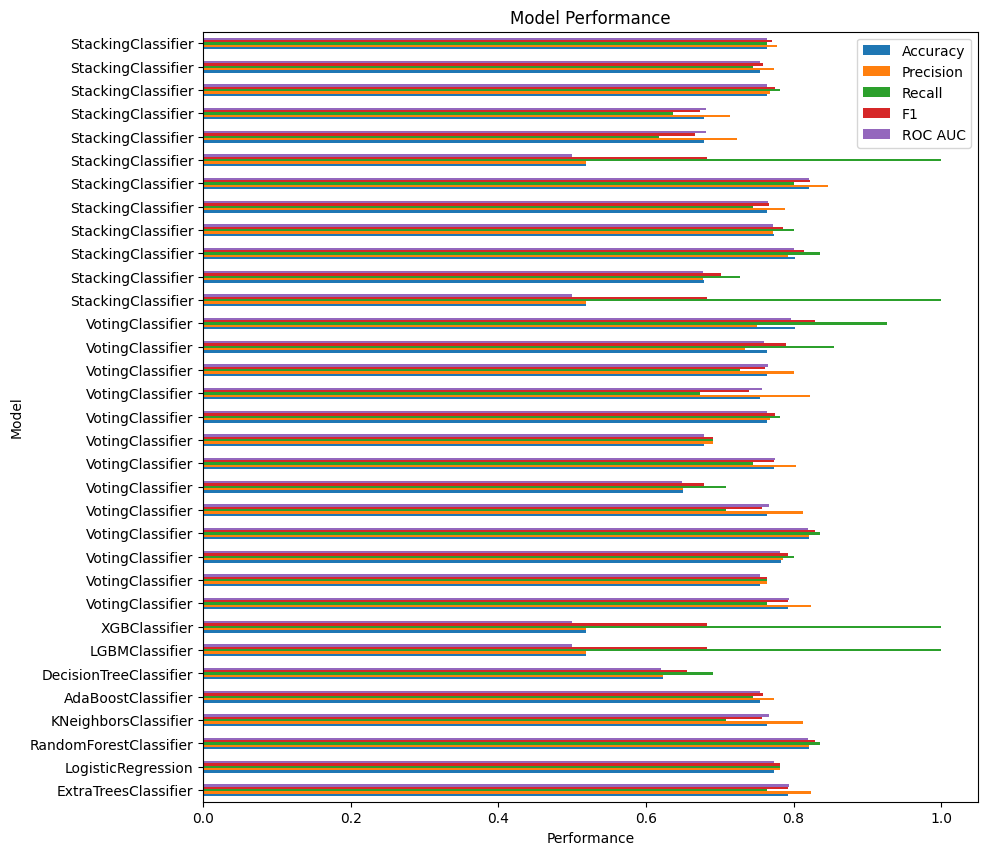

In [20]:
#make a graph of the from metrics.csv

results = pd.read_csv('metrics.csv', index_col=0)
results.plot(kind='barh', figsize=(10, 10))
plt.title('Model Performance')
plt.xlabel('Performance')
plt.ylabel('Model')
plt.legend(loc='upper right')
plt.savefig('model_performance.png')
plt.show()
